In [ ]:
%matplotlib inline



# Phase 2: Filter Design – Headfirst Notes

👉**Objective**

Design FIR filters (LP or RRC) to shape IQ signals for transmission and reception with minimal ISI.

👉**Key idea:**

    Transmit shaping: Use RRC filter to smooth pulses → avoids ISI.

    Receive shaping: Use matched RRC filter to reconstruct symbols.

    LP FIR filter: Optional for basic bandwidth control or pre-filtering.
---

## What We Will Do (Step-by-Step)

1. **Decide Filter Type & Parameters**
   - Low-Pass FIR or RRC
   - Filter order / number of taps
   - Cutoff frequency (normalized 0–1, 1 = Nyquist)
   - Window type (Hamming)
   - Span (for RRC, in symbols)

2. **Design the Filter**
   - Generate impulse response
   - Ensure symmetry for linear phase
   - Verify stability

3. **Analyze the Filter**
   - Plot frequency response (`freqz`)  
   - Check magnitude and phase  
   - Observe group delay if needed

4. **Document Observations**
   - Note the effect of order, cutoff, window
   - Comment on expected effect on IQ signal

---

**Tip:** Keep it headfirst — focus on *what the filter does*, *how it shapes the signal*, not just the code.


| Parameter      | Example Value     | Purpose                                                         |
| -------------- | ----------------- | --------------------------------------------------------------- |
| `num_taps`     | 55 → 121          | Number of filter coefficients; controls sharpness of transition |
| `span`         | 8 symbols         | Duration of RRC in symbols                                      |
| `sps`          | 32 samples/symbol | Determines oversampling rate                                    |
| `N`            | `span*sps+1`      | Ensures symmetric filter for linear phase                       |
| `beta`         | 0.8               | RRC roll-off factor; 0 → sharp, 1 → wide                        |
| `filter_delay` | `(N-1)/2`         | Group delay of the FIR filter (used for alignment)              |


In [48]:
import numpy as np
from scipy.signal import firwin
#Filter Design Paramerters
num_taps = 55  #Later as per output we can change it to 121 or so
signal = 4e03 # 4 Khz
fc = 1.2e03 #Cutoff Freq = 1.2 Khz 
R_sym = 1e03 #Symbol rate
sps =  32 #samples per symbol (upsampling)
fs = R_sym * sps # Sampling Freq
normalised_cutoff  = fc/(fs/2)
span =  8 
N = span*sps+1 #Length of the filter to be symmetric
beta = 0.8 # Roll Of for RRC filter
filter_delay = (N-1)//2  #Group delay of the FIR filter (used for alignment)

# Generate Filter Coefficients
h = firwin(num_taps, cutoff=normalised_cutoff, window='hamming')
print("The coefficients are:", h)
print("The No of coefficients are:", len(h))
print("The sum of coefficients", np.sum(h))

The coefficients are: [ 7.37030207e-05 -1.58536768e-04 -4.48419386e-04 -8.36576773e-04
 -1.35140030e-03 -1.99891597e-03 -2.75426734e-03 -3.55607486e-03
 -4.30469582e-03 -4.86503355e-03 -5.07407301e-03 -4.75280157e-03
 -3.72166274e-03 -1.81824327e-03  1.08443781e-03  5.06084716e-03
  1.01188669e-02  1.61903510e-02  2.31275575e-02  3.07061993e-02
  3.86352534e-02  4.65730294e-02  5.41483868e-02  6.09854687e-02
  6.67299384e-02  7.10745140e-02  7.37816061e-02  7.47010838e-02
  7.37816061e-02  7.10745140e-02  6.67299384e-02  6.09854687e-02
  5.41483868e-02  4.65730294e-02  3.86352534e-02  3.07061993e-02
  2.31275575e-02  1.61903510e-02  1.01188669e-02  5.06084716e-03
  1.08443781e-03 -1.81824327e-03 -3.72166274e-03 -4.75280157e-03
 -5.07407301e-03 -4.86503355e-03 -4.30469582e-03 -3.55607486e-03
 -2.75426734e-03 -1.99891597e-03 -1.35140030e-03 -8.36576773e-04
 -4.48419386e-04 -1.58536768e-04  7.37030207e-05]
The No of coefficients are: 55
The sum of coefficients 1.0000000000000004


👉 Next Step: Frequency Response Analysis (freqz)
   * Now we move from time-domain intuition to frequency-domain insight.
   * Goal: Understand how your filter behaves across the spectrum:
   * Which frequencies pass through?
   * Which frequencies are attenuated?
   * How much phase shift is introduced?
👉Key points:
   * w → array of frequencies in radians/sample, from 0 to π (Nyquist).
   * H → complex frequency response, encoding magnitude and phase.
   * Positive frequencies only because FIR filters are symmetric; negative side is mirror.

### **freqz = X-ray for your filter**

Think of your FIR filter like a **spinning wheel**, where each spoke is a **filter coefficient**:

1. **Spinning wheel (w):**

   * `w` is the set of **speeds** at which we spin the wheel — from 0 up to **Nyquist frequency (fs/2)**.
   * Each “speed” represents a different frequency we want to test.

2. **Filter coefficients (h):**

   * Each coefficient is like a **weight on the wheel spoke**.
   * When the wheel spins at a particular speed, the weights **push the wheel differently**, either helping it spin freely (pass) or slowing it down (attenuate).

3. **The interaction:**

   * For each frequency in `w`, the **sum of all weighted pushes** from `h` gives us **H**, the complex response at that frequency.
   * **Magnitude of H** → how strongly the filter **passes** that frequency.
   * **Phase of H** → whether the filter **delays or rotates** that frequency component.

4. **Why only 0 → π (or fs/2)?**

   * FIR filters are **symmetric**, so negative frequencies are just mirrors.
   * We only need the **positive half** to see everything the filter does.

---

### **Connecting to time-domain intuition**

* Magnitude = how much the filter allows each frequency to contribute to the output.
* Phase = how each frequency is **shifted in time** (delay).
* By combining all frequencies (via inverse Fourier ideas), you **reconstruct the filtered pulse** in time — just like we saw with the squit pulse example.

---

**Layman analogy:**

* Imagine a **slowly spinning merry-go-round**.
* Each board has a weight (filter coefficient).
* As you spin at different speeds (frequencies), the **push of the weights changes**.
* Some speeds spin easily → pass (magnitude high).
* Some speeds are resisted → blocked (magnitude low).
* The angle of the wheel at each spin = phase shift for that frequency.

---

In [49]:
from scipy.signal import freqz
w, H = freqz(h, worN=512)  # 512 points across 0 to π
print()


### Step 1: Digital frequency

Any **analog frequency** $f_\text{Hz}$ is converted to **radians/sample** by:

$$
\omega = 2 \pi \frac{f_\text{Hz}}{f_s}
$$

Where:  
- $f_\text{Hz}$ = frequency in Hz  
- $f_s$ = sampling frequency in Hz  
- $\omega$ = digital frequency in **radians/sample**, used in DSP formulas

---

### Step 2: freqz usage

- `freqz` returns `w` in **radians/sample**  
- The highest value $w = \pi$ → Nyquist ($f_s/2$)  
- To **convert back to Hz**:

$$
f_\text{Hz} = \frac{w}{2\pi} f_s
$$

Or equivalently (common simplification using Nyquist):

$$
f_\text{Hz} = \frac{w}{\pi} \cdot \frac{f_s}{2}
$$

---

### Step 3: Python example

```python
f_Hz = w / (2*np.pi) * fs    # or equivalently: w/np.pi * (fs/2)
plt.plot(f_Hz, abs(H))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('FIR Filter Magnitude Response')
plt.grid()
plt.show()


# **Headfirst Guide: Filters Talking to Spinning Wheels**

### 🎯 The Core Idea

Filters don’t just munch on random signals. The real trick is:
Any signal can be broken into a sum of **sinusoids** (the gears).
A **linear filter** treats each sinusoid in a very predictable way.

This is why **freqz** is our “X-ray machine”: it feeds in sinusoids one by one (from 0 → Nyquist) and tells us:

* How much the filter **amplifies or attenuates** (magnitude).
* How much it **rotates in time** (phase shift).

---

## **Step 1: Meet the Gear (Digital Sinusoid)**

A “gear” is just a **digitized sinusoid**, sampled at integer time steps:

[
$x[n] = e^{j \omega n}$
]

* ($\omega$) = digital frequency (radians/sample)
* ( n ) = sample index

For example, for $(\omega = \pi/2)$ rad/sample, one full cycle takes 4 samples. The samples look like:
$$
[
x[0] = 1, \quad x[1] = j, \quad x[2] = -1, \quad x[3] = -j, \quad x[4] = 1 \dots
]
$$
This is the digital “spinning gear” with 4 teeth.

---

## **Step 2: Filter Coefficients — the Weights**

A filter is defined by its **coefficients**, e.g., a 3-tap FIR filter:
$
[
h = [h_0, h_1, h_2]
]$

Each coefficient is a **weight** that pushes on delayed samples of the gear.
Longer filters → smoother pulses, better frequency shaping.

---

## **Step 3: The Interaction — Sliding & Summing**

The filter output is computed by convolution:
$[
y[n] = \sum_{k=0}^{N-1} h[k] x[n-k]
]$
* The filter “slides” across the sinusoid.
* Each coefficient multiplies the corresponding delayed sample and sums the results.
* This determines **how strongly and in which phase the gear spins after passing the filter**.

---

## **Step 4: Magnitude & Phase**

For each frequency $( \omega )$, the **complex response** is:
$[
H(\omega) = \sum_{k=0}^{N-1} h[k] e^{-j \omega k}
]$
* **Magnitude $(|H(\omega)|)$** → how much the gear is amplified or attenuated.
* **Phase $(\angle H(\omega))$** → how much the gear is rotated (time-shifted).

A sinusoid **does not change its shape** through a linear filter — only its amplitude and phase. This makes sinusoids perfect probes.

---

## **Step 5: freqz — The X-ray Machine**

* `freqz` generates an array of digital frequencies (w) from 0 → π radians/sample (0 → Nyquist).
* For each frequency (w[k]), it computes the filter response (H[k]) as above.
* This gives the **complete frequency response** of the filter.

---

## **Step 6: Converting Digital Frequency to Hz**

Digital frequency is related to real frequency:
$$
[
\omega = 2 \pi \frac{f_\text{Hz}}{f_s}
]
$$
To plot in Hz:
$$
[
f_\text{Hz} = \frac{\omega}{2\pi} f_s \quad \text{or} \quad f_\text{Hz} = \frac{w}{\pi} \cdot \frac{f_s}{2}
]
$$
* `fs` = sampling frequency in Hz
* This converts the x-axis from radians/sample to real-world Hz.

---

## **Step 7: One Complete Rotation is Enough**

Each sinusoid is **periodic**, so testing over one full cycle (0 → 2π) is sufficient to know the filter’s effect.

* `freqz` only goes to π (Nyquist) because for real filters, the response beyond Nyquist mirrors due to conjugate symmetry.

---

## **Step 8: Tiny Numeric Example**

**Filter:**  
$h = [0.5, 0.3, 0.2]$

**Gear frequency:**  
$\omega = \pi/2 \text{ rad/sample}$

**Compute the response:**

$H(\pi/2) = 0.5 \cdot 1 + 0.3 \cdot e^{-j \pi/2} + 0.2 \cdot e^{-j \pi} = 0.3 - 0.3j$

**Magnitude:**  
$|H| = 0.424$ → attenuated

**Phase:**  
$\angle H = -45^\circ$ → rotated

Input sinusoid comes out **same shape**, just scaled and phase-shifted. That’s the magic of FIR filtering.

### ✅ Summary

* A digital sinusoid = the “gear.”
* Filter coefficients = weights pushing the gear.
* Convolution = sliding the filter over the gear and summing the effect.
* `freqz` = test all gears from 0 → Nyquist and report **magnitude + phase**.
* Magnitude + phase = filter’s “personality profile” for that frequency.

In [50]:
f_Hz = w / (2*np.pi) * fs
print("Length of w converted to freq", len(f_Hz))

Length of w converted to freq 512


Length of sps 32
This is upsampled signal 96
Upsampled signal: [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
Length of filtered (convoluted) output: 150


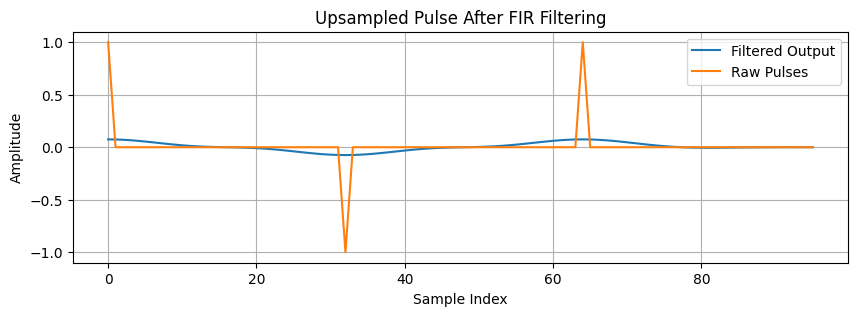

In [60]:
%matplotlib inline
plt.close('all')  # closes any old figures
# --- Symbols and Upsampling ---
symbols = np.array([+1, -1, +1])
print("Length of sps", sps)
upsampled = np.zeros(len(symbols)*sps)
upsampled[::sps] = symbols
print("This is upsampled signal", len(upsampled))
print("Upsampled signal:", upsampled)

# --- Convolution with FIR filter ---
h = h / np.sum(h)
y = np.convolve(upsampled, h, mode='full')
print("Length of filtered (convoluted) output:", len(y))
filter_delay = (len(h)-1)//2
# Compensate for filter delay
y_aligned = y[filter_delay:(filter_delay + len(upsampled))]

#Plotting the Signal
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.title("Upsampled Pulse After FIR Filtering")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.plot(y_aligned, label="Filtered Output")
plt.plot(upsampled, label="Raw Pulses")
plt.legend()
plt.grid(True)


import os

# Create folder if it doesn't exist
os.makedirs("plots", exist_ok=True)

# Now save the figure
plt.savefig("plots/filtered_output.png")
plt.show()
